# Policy based methods

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import optax

from jax import nn
from typing import NamedTuple
from functools import partial

## Policy methods vs value methods

The TD methods that we learned were focused on estimating the optimal value of being in a particular state - There was a policy function but it was simply derived as a function of the value function.

Policy based methods are going to put the policy function front-and-center. We're also going to use policy based methods as a stepping stone to transition from discrete states to continuous states but we will keep actions discrete for now.

## Example model

We're going to start with a McCall model with job separation. Wages are going to be drawn from a continuous distribution $F(w)$ -- We will choose to draw log wages from a normal distribution.

If an individual accepts a wage $w$ then they begin working at that wage in the next period and have a probability $\alpha$ of losing their job which takes effect in the next period. While the worker is unemployed, they receive unemployment compensation $c$.

The individual consumes all of their income each period and has a utility function $u$ that satisfies the "usual conditions"

**The state**

Each period's state is going to be the current wage offer.

Note that if we were to solve this with dynamic programming, then we would simply discretize the wage offers and solve over a grid of wages. We are not going to directly discretize in our solution -- If we did, we could solve this with discrete TD methods similar to what we saw before.

In [11]:
class Model(NamedTuple):
    """
    Stores parameters for the McCall model.
    """
    γ: float = 2.0
    β: float = 0.85
    μ_w: float = 0.0
    σ_w: float = 1.0
    c: float = 1.
    α: float = 0.1


def u(c, γ):
    """CRRA utility function."""
    c = jnp.maximum(c, 1e-10)
    return c**(1 - γ) / (1 - γ)


class LayerParams(NamedTuple):
    """
    Stores parameters for one layer of the neural network.
    """
    W: jnp.ndarray     # weights
    b: jnp.ndarray     # biases


class Config:
    """
    Configuration for training the policy network.
    """
    seed = 20251204
    epochs = 500
    episode_length = 10
    num_episodes = 25
    layer_sizes = (1, 32, 32, 2)
    init_lr = 0.05
    min_lr = 0.0005
    warmup_steps = 500
    decay_steps = 250

In [12]:
0.85**10

0.1968744043407226

## Policy method

Policy methods are going to start by having/guessing a policy function.

Your instinct is probably to think of a policy function as a mapping from states to an action, something like

$$\pi^*(s): \mathcal{R}^N \rightarrow \mathcal{A}$$

However, instead of mapping directly to the action space, we're going to map to a probabliity distribution over the action space.

This means our policies are going to be stochastic (or at least potentially stochastic).

There are a couple of reasons for this:

* We may not need to directly hard-code the explore piece of the policy (something like $\epsilon$-greedy) because it is baked into the policy.
* Policy based methods that output a distribution are going to play more nicely as we move into high dimensional action spaces or continuous action spaces


Below we define an initial policy function that's a simple Jax neural network with one input (the wage) and two outputs (the probabilities of rejecting or accepting the job):

In [13]:
def initialize_layer(in_dim, out_dim, key, s=None):
    """
    Initialize weights and biases for a single layer.
    Use LeCun initialization.
    """
    if s is None:
        s = jnp.sqrt(1.0 / in_dim)
    W = jax.random.normal(key, (in_dim, out_dim)) * s
    b = jnp.zeros((out_dim,))

    return LayerParams(W, b)


def initialize_network(key, layer_sizes):
    """
    Build a network by initializing all of the parameters.
    A network is a list of LayerParams instances.
    """
    params = []
    for i in range(len(layer_sizes) - 2):
        key, subkey = jax.random.split(key)

        layer = initialize_layer(
            layer_sizes[i],
            layer_sizes[i + 1],
            subkey
        )
        params.append(layer)

    # Do last layer separately
    key, subkey = jax.random.split(key)
    layer = initialize_layer(layer_sizes[-2], layer_sizes[-1], subkey, 0.0001)
    params.append(layer)

    return params


def forward(params, w):
    """
    Evaluate neural network policy: maps a wage w to 
    probabilities over actions [reject, accept].
    
    Returns a 2-element array with probabilities.
    """
    σ = jax.nn.selu
    x = jnp.array((w,))  # Make state a 1D array
    
    # Forward pass through hidden layers
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    
    # Final layer outputs logits
    W, b = params[-1]
    logits = x @ W + b
    
    # Convert to probabilities using softmax
    probs = jax.nn.softmax(logits)
    
    return probs

# Initialize the network
key = jax.random.PRNGKey(Config.seed)
params = initialize_network(key, Config.layer_sizes)

print("Policy network initialized!")
print(f"Network architecture: {Config.layer_sizes}")

Policy network initialized!
Network architecture: (1, 32, 32, 2)


Here we plot the probabilities across the wages for the initial policy.

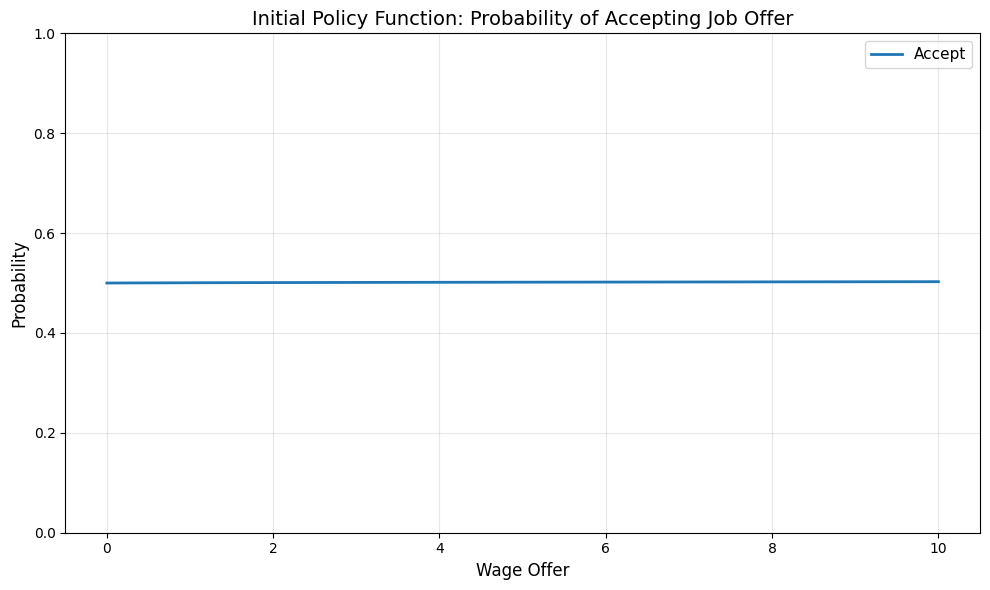

At low wage (w=0.00): P(accept)=0.500
At medium wage (w=5.05): P(accept)=0.502
At high wage (w=10.00): P(accept)=0.503


In [14]:
# Create a grid of wage values
w_grid = jnp.linspace(0.0, 10.0, 100)

# Vectorize the forward function to evaluate over the grid
policy_vmap = jax.vmap(lambda w: forward(params, w))
probs_grid = policy_vmap(w_grid)

# Extract probabilities for accept (1)
prob_accept = probs_grid[:, 1]

# Plot the probabilities
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w_grid, prob_accept, label='Accept', linewidth=2)

ax.set_xlabel('Wage Offer', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Initial Policy Function: Probability of Accepting Job Offer', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"At low wage (w={w_grid[0]:.2f}): P(accept)={prob_accept[0]:.3f}")
print(f"At medium wage (w={w_grid[50]:.2f}): P(accept)={prob_accept[50]:.3f}")
print(f"At high wage (w={w_grid[-1]:.2f}): P(accept)={prob_accept[-1]:.3f}")

## Policy gradient algorithm

The policy gradient algorithm looks like what John described this morning except, rather than have a deterministic policy, we have a potentially stochastic policy.

In [ ]:
@partial(jax.jit, static_argnames=('episode_length',))
def simulate_episode(key, params, model, episode_length):
    """
    Simulate one episode following the policy defined by params.
    Uses jax.lax.scan for efficient compilation.
    
    Returns:
        rewards: Array of rewards received (length episode_length)
        log_probs: Array of log probabilities of actions (length episode_length)
        decision_mask: Binary mask indicating when decisions were made
    """
    γ, β, μ_w, σ_w, c, α = model.γ, model.β, model.μ_w, model.σ_w, model.c, model.α
    
    def step_fn(carry, t):
        key, employed, current_wage = carry
        key, wage_key, action_key, separation_key = jax.random.split(key, 4)
        
        # Generate wage offer (always, even if employed)
        log_wage_offer = μ_w + jax.random.normal(wage_key)*σ_w
        wage_offer = jnp.exp(log_wage_offer)

        # Determine if we make a decision this step
        making_decision = ~employed
        
        # Get policy probabilities (computed even if not used)
        probs = forward(params, wage_offer)
        
        # Sample action (0=reject, 1=accept) -- `jax.random.categorical` takes
        # logits, not probabilities
        action = jax.random.categorical(action_key, jnp.log(probs + 1e-10))        
        log_prob = jnp.log(probs[action] + 1e-10)

        # Compute reward and next state based on current employment status
        def unemployed_branch():
            reward_reject = u(c, γ)
            reward_accept = u(wage_offer, γ)
            reward = jnp.where(action == 0, reward_reject, reward_accept)
            new_employed = action == 1
            new_wage = jnp.where(action == 1, wage_offer, 0.0)
            return reward, new_employed, new_wage
        
        def employed_branch():
            # Check if lose job
            lose_job = jax.random.uniform(separation_key) < α
            reward = jnp.where(lose_job, 0.0, u(current_wage, γ))
            new_employed = ~lose_job
            new_wage = jnp.where(lose_job, 0.0, current_wage)
            return reward, new_employed, new_wage
        
        reward, new_employed, new_wage = jax.lax.cond(
            employed,
            employed_branch,
            unemployed_branch
        )
        
        # Only use log_prob if we made a decision
        log_prob_masked = jnp.where(making_decision, log_prob, 0.0)
        
        new_carry = (key, new_employed, new_wage)
        output = (reward, log_prob_masked, making_decision)
        
        return new_carry, output
    
    # Initial state: unemployed, no wage
    init_carry = (key, False, 0.0)
    
    # Run the scan
    final_carry, outputs = jax.lax.scan(step_fn, init_carry, jnp.arange(episode_length))
    
    rewards, log_probs, decision_mask = outputs
    
    return rewards, log_probs, decision_mask


@jax.jit
def compute_returns(rewards, β):
    """Compute discounted returns for each timestep using scan."""
    def scan_fn(G, reward):
        new_G = reward + β * G
        return new_G, new_G
    
    # Scan backwards through rewards
    _, returns = jax.lax.scan(scan_fn, 0.0, rewards, reverse=True)
    return returns


@partial(jax.jit, static_argnames=('episode_length', 'num_episodes'))
def policy_gradient_loss(params, model, key, episode_length, num_episodes):
    """
    Compute the REINFORCE policy gradient loss.
    Uses vmap to vectorize over episodes for speed.
    """
    # Generate keys for all episodes
    keys = jax.random.split(key, num_episodes)
    
    # Vectorize simulate_episode over episodes
    simulate_batch = jax.vmap(
        lambda k: simulate_episode(k, params, model, episode_length)
    )
    
    # Simulate all episodes in parallel
    rewards_batch, log_probs_batch, decision_mask_batch = simulate_batch(keys)
    
    # Compute returns for all episodes
    returns_batch = jax.vmap(lambda r: compute_returns(r, model.β))(rewards_batch)
    
    # Normalize returns per episode
    def normalize_returns(returns):
        mean = jnp.mean(returns)
        std = jnp.std(returns)
        return (returns - mean) / (std + 1e-10)
    
    returns_normalized = jax.vmap(normalize_returns)(returns_batch)
    
    # Compute loss: only include log_probs where decisions were made
    # Multiply by decision_mask to zero out non-decision timesteps
    losses = -jnp.sum(log_probs_batch * returns_normalized * decision_mask_batch, axis=1)

    return jnp.mean(losses)

def create_lr_schedule():
    """Create learning rate schedule."""
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=Config.init_lr,
        transition_steps=Config.warmup_steps
    )
    
    decay_fn = optax.exponential_decay(
        init_value=Config.init_lr,
        transition_steps=Config.decay_steps,
        decay_rate=0.5,
        end_value=Config.min_lr
    )
    
    return optax.join_schedules(
        schedules=[warmup_fn, decay_fn],
        boundaries=[Config.warmup_steps]
    )

# Create model and optimizer
model = Model()
lr_schedule = create_lr_schedule()
optimizer = optax.adam(learning_rate=lr_schedule)

# Re-initialize parameters for training
key = jax.random.PRNGKey(Config.seed)
params = initialize_network(key, Config.layer_sizes)
opt_state = optimizer.init(params)

# Training loop
loss_history = []
best_loss = jnp.inf
best_params = params

print("Training policy")
for epoch in range(Config.epochs):
    key, subkey = jax.random.split(key)
    
    # Compute loss and gradients (JIT compiled!)
    loss, grads = jax.value_and_grad(policy_gradient_loss)(
        params, model, subkey, Config.episode_length, Config.num_episodes
    )
    
    loss_history.append(float(loss))
    
    # Track best parameters
    if loss < best_loss:
        best_loss = loss
        best_params = params
    
    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{Config.epochs}: Loss = {loss:.4f}")
        Config.episode_length = Config.episode_length+5

# Use best parameters
params = best_params
print(f"\nTraining complete! Best loss: {best_loss:.4f}")

Training policy
Epoch 0/500: Loss = -1.0839
Epoch 100/500: Loss = -0.1922
Epoch 200/500: Loss = -0.4766
Epoch 300/500: Loss = -0.1623
Epoch 400/500: Loss = -0.1535

Training complete! Best loss: -3.7392


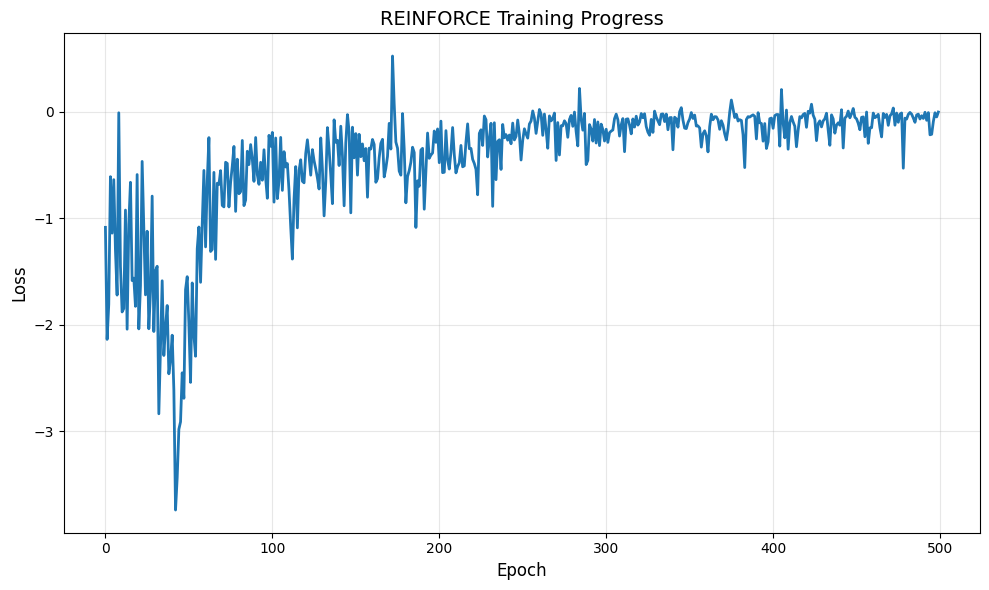

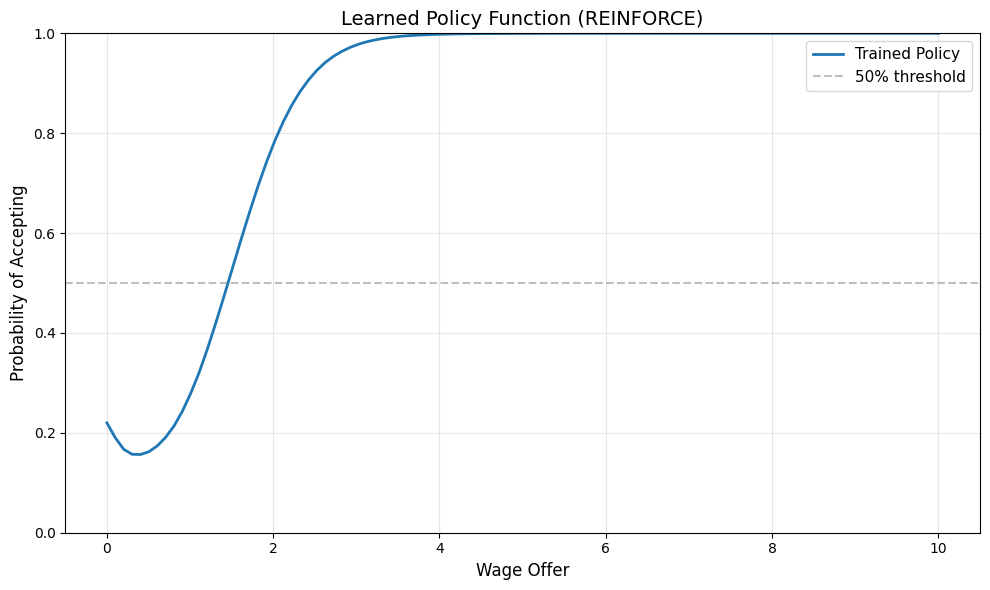


Policy characteristics:
At low wage (w=0.00): P(accept)=0.220
At medium wage (w=5.05): P(accept)=1.000
At high wage (w=10.00): P(accept)=1.000


In [17]:
# Plot learning progress
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_history, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('REINFORCE Training Progress', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot learned policy
w_grid_trained = jnp.linspace(0.0, 10.0, 100)
policy_vmap_trained = jax.vmap(lambda w: forward(params, w))
probs_grid_trained = policy_vmap_trained(w_grid_trained)
prob_accept_trained = probs_grid_trained[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w_grid_trained, prob_accept_trained, linewidth=2, label='Trained Policy')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax.set_xlabel('Wage Offer', fontsize=12)
ax.set_ylabel('Probability of Accepting', fontsize=12)
ax.set_title('Learned Policy Function (REINFORCE)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"\nPolicy characteristics:")
print(f"At low wage (w={w_grid_trained[0]:.2f}): P(accept)={prob_accept_trained[0]:.3f}")
print(f"At medium wage (w={w_grid_trained[50]:.2f}): P(accept)={prob_accept_trained[50]:.3f}")
print(f"At high wage (w={w_grid_trained[-1]:.2f}): P(accept)={prob_accept_trained[-1]:.3f}")

## Actor-critic algorithm

The policy methods described above depend quite heavily on sampling...

![Actor-Critic](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/ac.jpg)

^Image credit to HuggingFace RL course

**Advantage Actor Critic**

Training Actor-Critic (optimized with scan + vmap)...
Compiling functions on first iteration...
Epoch 0/2500: Actor Loss = 0.0008, Critic Loss = 55.6157
Epoch 50/2500: Actor Loss = -0.9629, Critic Loss = 63.2050
Epoch 100/2500: Actor Loss = -6.6183, Critic Loss = 59.8769
Epoch 150/2500: Actor Loss = -2.1860, Critic Loss = 2.0082
Epoch 200/2500: Actor Loss = -1.1871, Critic Loss = 1.1294
Epoch 250/2500: Actor Loss = -0.6774, Critic Loss = 1.0695
Epoch 300/2500: Actor Loss = -0.9880, Critic Loss = 0.9871
Epoch 350/2500: Actor Loss = -1.7912, Critic Loss = 0.9991
Epoch 400/2500: Actor Loss = -1.2690, Critic Loss = 1.1043
Epoch 450/2500: Actor Loss = -1.4501, Critic Loss = 1.2211
Epoch 500/2500: Actor Loss = -0.6090, Critic Loss = 1.2703
Epoch 550/2500: Actor Loss = -1.2180, Critic Loss = 1.3307
Epoch 600/2500: Actor Loss = -1.3157, Critic Loss = 1.3190
Epoch 650/2500: Actor Loss = -0.7822, Critic Loss = 1.2531
Epoch 700/2500: Actor Loss = -0.8671, Critic Loss = 1.1117
Epoch 750/2500: Acto

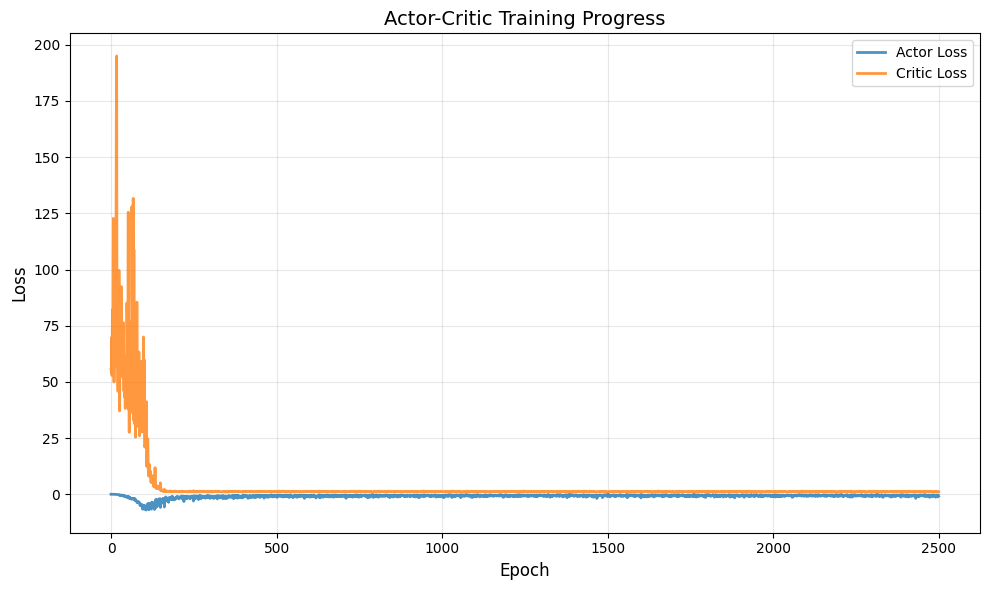

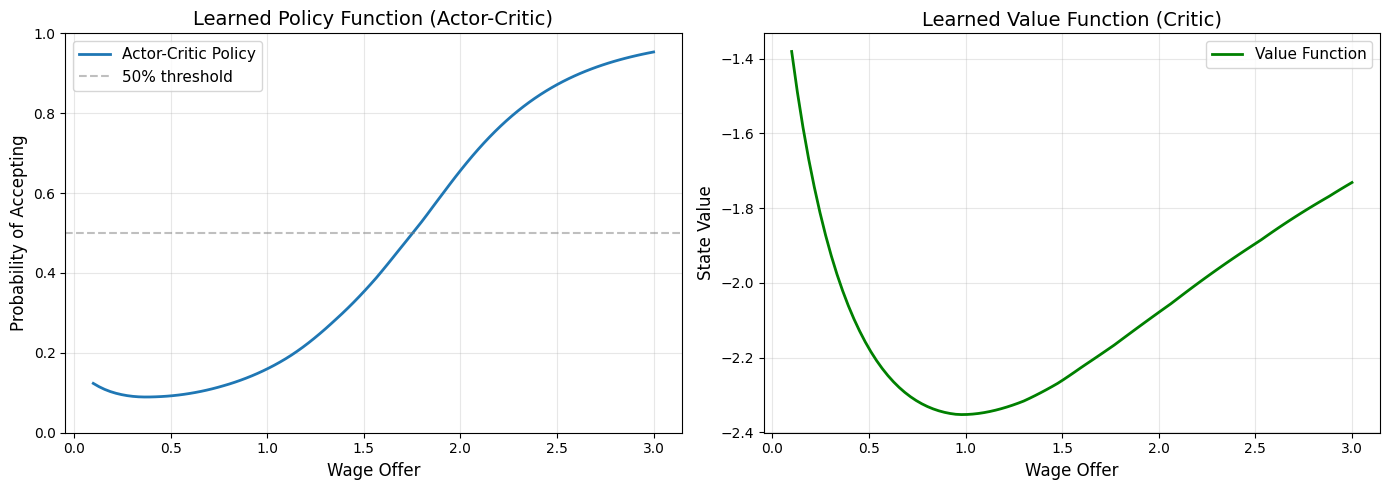


Policy characteristics:
At low wage (w=0.10): P(accept)=0.124, V=-1.381
At medium wage (w=1.56): P(accept)=0.388, V=-2.239
At high wage (w=3.00): P(accept)=0.953, V=-1.731


In [16]:
class ConfigAC:
    """
    Configuration for training the actor-critic network.
    """
    seed = 43
    epochs = 2500
    episode_length = 100
    num_episodes = 25
    actor_layer_sizes = 1, 32, 32, 2  # Policy network
    critic_layer_sizes = 1, 32, 32, 1  # Value network
    init_lr = 0.001
    min_lr = 0.00001
    warmup_steps = 100
    decay_steps = 400

def forward_value(params, w):
    """
    Evaluate value network: maps a wage w to its estimated value.
    """
    σ = jax.nn.selu
    x = jnp.array((w,))
    
    # Forward pass through hidden layers
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    
    # Final layer outputs value (no activation)
    W, b = params[-1]
    value = (x @ W + b)[0]
    
    return value

@partial(jax.jit, static_argnames=('episode_length',))
def simulate_episode_ac(key, actor_params, critic_params, model, episode_length):
    """
    Simulate one episode for actor-critic.
    Computes TD errors on the fly with proper next-state value estimation.
    
    Returns:
        rewards: Array of rewards
        log_probs: Array of log probabilities
        values: Array of state values
        next_values: Array of next state values (for TD error)
        decision_mask: Binary mask for decisions
    """
    γ, β, σ_w, c, α = model.γ, model.β, model.σ_w, model.c, model.α
    
    def step_fn(carry, t):
        key, employed, current_wage = carry
        key, k1, k2, k3, k4 = jax.random.split(key, 5)
        
        # Generate current wage offer
        wage_offer = jnp.exp(jax.random.normal(k1) * σ_w)
        
        # Pre-generate NEXT wage offer (for bootstrapping next value)
        next_wage_offer = jnp.exp(jax.random.normal(k4) * σ_w)
        
        # Determine if making decision
        making_decision = ~employed
        
        # Get policy probabilities and value for current state
        probs = forward(actor_params, wage_offer)
        value = forward_value(critic_params, wage_offer)
        
        # Sample action
        action = jax.random.categorical(k2, jnp.log(probs + 1e-10))
        log_prob = jnp.log(probs[action] + 1e-10)
        
        # Compute reward and next state
        def unemployed_branch():
            reward_reject = u(c, γ)
            reward_accept = u(wage_offer, γ)
            reward = jnp.where(action == 0, reward_reject, reward_accept)
            new_employed = action == 1
            new_wage = jnp.where(action == 1, wage_offer, 0.0)
            # Next value: if accept, value of that wage; if reject, value of next draw
            next_val_wage = jnp.where(action == 1, wage_offer, next_wage_offer)
            return reward, new_employed, new_wage, next_val_wage
        
        def employed_branch():
            lose_job = jax.random.uniform(k3) < α
            reward = jnp.where(lose_job, 0.0, u(current_wage, γ))
            new_employed = ~lose_job
            new_wage = jnp.where(lose_job, 0.0, current_wage)
            # Next value: if keep job, value of current wage; if lose, value of next draw
            next_val_wage = jnp.where(lose_job, next_wage_offer, current_wage)
            return reward, new_employed, new_wage, next_val_wage
        
        reward, new_employed, new_wage, next_val_wage = jax.lax.cond(
            employed,
            employed_branch,
            unemployed_branch
        )
        
        # Compute next state value
        next_value = forward_value(critic_params, next_val_wage)
        
        # Mask outputs (only for decisions made)
        log_prob_masked = jnp.where(making_decision, log_prob, 0.0)
        value_masked = jnp.where(making_decision, value, 0.0)
        next_value_masked = jnp.where(making_decision, next_value, 0.0)
        
        new_carry = (key, new_employed, new_wage)
        output = (reward, log_prob_masked, value_masked, next_value_masked, making_decision)
        
        return new_carry, output
    
    init_carry = (key, False, 0.0)
    final_carry, outputs = jax.lax.scan(step_fn, init_carry, jnp.arange(episode_length))
    
    rewards, log_probs, values, next_values, decision_mask = outputs
    
    return rewards, log_probs, values, next_values, decision_mask

@partial(jax.jit, static_argnames=('episode_length', 'num_episodes'))
def actor_critic_loss(actor_params, critic_params, model, key, episode_length, num_episodes):
    """
    Compute actor-critic loss.
    Actor loss: -log π(a|s) * advantage
    Critic loss: (V(s) - target)^2
    """
    keys = jax.random.split(key, num_episodes)
    
    # Vectorize over episodes
    simulate_batch = jax.vmap(
        lambda k: simulate_episode_ac(k, actor_params, critic_params, model, episode_length)
    )
    
    # Simulate all episodes
    rewards_batch, log_probs_batch, values_batch, next_values_batch, decision_mask_batch = simulate_batch(keys)
    
    # Compute TD errors (advantages)
    # advantage = reward + γ * V(s') - V(s)
    td_targets = rewards_batch + model.β * next_values_batch
    advantages = td_targets - values_batch
    
    # Normalize advantages per episode for actor loss
    def normalize_advantages(adv, mask):
        masked_adv = jnp.where(mask, adv, 0.0)
        num_decisions = jnp.sum(mask) + 1e-10
        mean = jnp.sum(masked_adv) / num_decisions
        var = jnp.sum(mask * (adv - mean)**2) / num_decisions
        std = jnp.sqrt(var + 1e-10)
        return (adv - mean) / (std + 1e-10)
    
    advantages_normalized = jax.vmap(normalize_advantages)(advantages, decision_mask_batch)
    
    # Actor loss: policy gradient with normalized advantage
    actor_losses = -jnp.sum(log_probs_batch * advantages_normalized * decision_mask_batch, axis=1)
    
    # Critic loss: MSE between value and TD target
    critic_losses = jnp.sum(decision_mask_batch * (values_batch - td_targets)**2, axis=1)
    
    # Average over episodes
    actor_loss = jnp.mean(actor_losses)
    critic_loss = jnp.mean(critic_losses)
    
    return actor_loss, critic_loss

def create_lr_schedule_ac():
    """Create learning rate schedule for actor-critic."""
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=ConfigAC.init_lr,
        transition_steps=ConfigAC.warmup_steps
    )
    
    decay_fn = optax.exponential_decay(
        init_value=ConfigAC.init_lr,
        transition_steps=ConfigAC.decay_steps,
        decay_rate=0.5,
        end_value=ConfigAC.min_lr
    )
    
    return optax.join_schedules(
        schedules=[warmup_fn, decay_fn],
        boundaries=[ConfigAC.warmup_steps]
    )

# Initialize actor and critic networks
model_ac = Model()
key_ac = jax.random.PRNGKey(ConfigAC.seed)
key_ac, actor_key, critic_key = jax.random.split(key_ac, 3)

actor_params = initialize_network(actor_key, ConfigAC.actor_layer_sizes)
critic_params = initialize_network(critic_key, ConfigAC.critic_layer_sizes)

# Create optimizers for both networks
lr_schedule_ac = create_lr_schedule_ac()
actor_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_schedule_ac)
)
critic_optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_schedule_ac)
)

actor_opt_state = actor_optimizer.init(actor_params)
critic_opt_state = critic_optimizer.init(critic_params)

# Training loop
actor_loss_history = []
critic_loss_history = []
best_actor_loss = jnp.inf
best_actor_params = actor_params
best_critic_params = critic_params

print("Training Actor-Critic (optimized with scan + vmap)...")
print("Compiling functions on first iteration...")

for epoch in range(ConfigAC.epochs):
    key_ac, subkey = jax.random.split(key_ac)
    
    # Compute gradients for both actor and critic
    def actor_loss_fn(a_params):
        actor_l, critic_l = actor_critic_loss(
            a_params, critic_params, model_ac, subkey, 
            ConfigAC.episode_length, ConfigAC.num_episodes
        )
        return actor_l
    
    def critic_loss_fn(c_params):
        actor_l, critic_l = actor_critic_loss(
            actor_params, c_params, model_ac, subkey, 
            ConfigAC.episode_length, ConfigAC.num_episodes
        )
        return critic_l
    
    # Compute losses and gradients
    actor_loss, actor_grads = jax.value_and_grad(actor_loss_fn)(actor_params)
    critic_loss, critic_grads = jax.value_and_grad(critic_loss_fn)(critic_params)
    
    actor_loss_history.append(float(actor_loss))
    critic_loss_history.append(float(critic_loss))
    
    # Track best parameters based on actor loss
    if actor_loss < best_actor_loss:
        best_actor_loss = actor_loss
        best_actor_params = actor_params
        best_critic_params = critic_params
    
    # Update parameters
    actor_updates, actor_opt_state = actor_optimizer.update(actor_grads, actor_opt_state)
    actor_params = optax.apply_updates(actor_params, actor_updates)
    
    critic_updates, critic_opt_state = critic_optimizer.update(critic_grads, critic_opt_state)
    critic_params = optax.apply_updates(critic_params, critic_updates)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{ConfigAC.epochs}: "
              f"Actor Loss = {actor_loss:.4f}, Critic Loss = {critic_loss:.4f}")

# Use best parameters
actor_params = best_actor_params
critic_params = best_critic_params
print(f"\nTraining complete! Best actor loss: {best_actor_loss:.4f}")

# Plot learning progress
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(actor_loss_history, linewidth=2, label='Actor Loss', alpha=0.8)
ax.plot(critic_loss_history, linewidth=2, label='Critic Loss', alpha=0.8)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Actor-Critic Training Progress', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot learned policy and value function
w_grid_ac = jnp.linspace(0.1, 3.0, 100)
policy_vmap_ac = jax.vmap(lambda w: forward(actor_params, w))
value_vmap_ac = jax.vmap(lambda w: forward_value(critic_params, w))

probs_grid_ac = policy_vmap_ac(w_grid_ac)
prob_accept_ac = probs_grid_ac[:, 1]
values_grid_ac = value_vmap_ac(w_grid_ac)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot policy
ax1.plot(w_grid_ac, prob_accept_ac, linewidth=2, label='Actor-Critic Policy')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax1.set_xlabel('Wage Offer', fontsize=12)
ax1.set_ylabel('Probability of Accepting', fontsize=12)
ax1.set_title('Learned Policy Function (Actor-Critic)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot value function
ax2.plot(w_grid_ac, values_grid_ac, linewidth=2, color='green', label='Value Function')
ax2.set_xlabel('Wage Offer', fontsize=12)
ax2.set_ylabel('State Value', fontsize=12)
ax2.set_title('Learned Value Function (Critic)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPolicy characteristics:")
print(f"At low wage (w={w_grid_ac[0]:.2f}): P(accept)={prob_accept_ac[0]:.3f}, V={values_grid_ac[0]:.3f}")
print(f"At medium wage (w={w_grid_ac[50]:.2f}): P(accept)={prob_accept_ac[50]:.3f}, V={values_grid_ac[50]:.3f}")
print(f"At high wage (w={w_grid_ac[-1]:.2f}): P(accept)={prob_accept_ac[-1]:.3f}, V={values_grid_ac[-1]:.3f}")

In [ ]:
np.exp(-1.0 + 1**2 / 2)

In [ ]:
plt.hist(jnp.exp(-1.0 + jax.random.normal(key, 100)*1))

In [ ]:
jnp.exp(-1.0 + jax.random.normal(key, 100))